google/vivit-b-16x2 <br>
https://huggingface.co/google/vivit-b-16x2 <br>
https://huggingface.co/docs/transformers/main/model_doc/vivit

# Import Library

In [20]:
!pip uninstall -y tensorflow

In [21]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu121
GPU available: 1


In [22]:
#!nvcc --version

In [23]:
# For data augmentation
from torchvision import transforms

In [24]:
#!pip install -q transformers==4.35.0

In [25]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor, VivitConfig

# For Model
from transformers import VivitModel, VivitForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [26]:
!pip install -q datasets #==2.10.0

In [27]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [28]:
#!pip install -q accelerate==0.21.0

In [29]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [30]:
!pip install -q decord

In [31]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [32]:
#!pip install -q av

In [33]:
!pip install -q tensorboard

In [34]:
from torch.utils.tensorboard import SummaryWriter

In [35]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [37]:
#pose_landmark_model = !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#hand_landmark_model = !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [40]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [41]:
BATCH_SIZE = 8
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'google/vivit-b-16x2'

FRAME_STEPS = 4
print('FRAME_STEPS =',FRAME_STEPS)

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('CLIP_LENGTH =',CLIP_LENGTH)

CLIP_HEIGHT = 640
CLIP_WIDTH = 480
print('Image Dimension =', CLIP_WIDTH,'X', CLIP_HEIGHT)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 8
BUFFER_SIZE = 64
FRAME_STEPS = 4
CLIP_LENGTH = 32
Image Dimension = 480 X 640
Image Dimension = 224 X 224


In [42]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [43]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [44]:
seed_everything(42)

# Import Data

In [45]:
data_dir = f'{gdrive_path}/Data'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/Data


In [46]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [47]:
print(local_path)

/content/SignLanguage


In [48]:
classes = sorted(os.listdir(local_path))
print(classes)

['warm', 'wet', 'wide', 'young']


In [49]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(local_path):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [50]:
print(label_to_idx)

{'warm': 0, 'wet': 1, 'wide': 2, 'young': 3}


In [51]:
print(idx_to_label)

{0: 'warm', 1: 'wet', 2: 'wide', 3: 'young'}


In [52]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [53]:
print('input path size:', len(video_path))
print(video_path)

input path size: 84
['/content/SignLanguage/warm/MVI_5223.MOV', '/content/SignLanguage/warm/MVI_9253.MOV', '/content/SignLanguage/warm/MVI_5301.MOV', '/content/SignLanguage/warm/MVI_9417.MOV', '/content/SignLanguage/warm/MVI_9415.MOV', '/content/SignLanguage/warm/MVI_5224.MOV', '/content/SignLanguage/warm/MVI_9494.MOV', '/content/SignLanguage/warm/MVI_9495.MOV', '/content/SignLanguage/warm/MVI_9254.MOV', '/content/SignLanguage/warm/MVI_5222.MOV', '/content/SignLanguage/warm/MVI_5143.MOV', '/content/SignLanguage/warm/MVI_5141.MOV', '/content/SignLanguage/warm/MVI_5302.MOV', '/content/SignLanguage/warm/MVI_9334.MOV', '/content/SignLanguage/warm/MVI_5144.MOV', '/content/SignLanguage/warm/MVI_9336.MOV', '/content/SignLanguage/warm/MVI_9335.MOV', '/content/SignLanguage/warm/MVI_9255.MOV', '/content/SignLanguage/warm/MVI_9493.MOV', '/content/SignLanguage/warm/MVI_9416.MOV', '/content/SignLanguage/warm/MVI_5303.MOV', '/content/SignLanguage/wet/MVI_9274.MOV', '/content/SignLanguage/wet/MVI_532

In [54]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 84
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [55]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 84
['warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'warm', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wet', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'wide', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young', 'young']


# Train Test Split

In [56]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=42)
#train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=42)

In [57]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
#print('Test data size:',len(test_path))

Train data size: 67
Val data size: 17


In [58]:
train_label[:5]

[0, 0, 3, 0, 2]

# Validating the input data - NOT USED

In [ ]:
#idx = 2
#train_path[idx]

'/content/SignLanguage/warm/MVI_5223.MOV'

In [ ]:
#vr_demo = VideoReader(train_path[idx])#, width=CLIP_WIDTH, height=CLIP_HEIGHT)

In [ ]:
#print('Number of Fames in the video:',len(vr_demo))

Number of Fames in the video: 62


In [ ]:
#frame = vr_demo[1]
#print('Shape of the frame:',frame.shape)

Shape of the frame: torch.Size([1080, 1920, 3])


In [ ]:
#key_indices = vr_demo.get_key_indices()
#key_frames = vr_demo.get_batch(key_indices)
#print(key_frames.shape)

torch.Size([6, 1080, 1920, 3])


In [ ]:
#print(key_frames.permute(0, 3, 1, 2).shape)

torch.Size([6, 3, 1080, 1920])


In [ ]:
#image_processor_demo = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
#                                                           size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT},
#                                                           crop_size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT}
#                                                           )

preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [ ]:
#model_inputs_demo = image_processor_demo.preprocess(videos=list(key_frames),
#                                               return_tensors='pt',
#                                               input_data_format='channels_last', # image in (height, width, num_channels) format.
#                                               )

In [ ]:
#print(model_inputs_demo.pixel_values.shape)

torch.Size([1, 6, 3, 640, 480])


In [ ]:
#reshaped_video = model_inputs_demo.pixel_values[0].permute(0, 2, 3, 1)

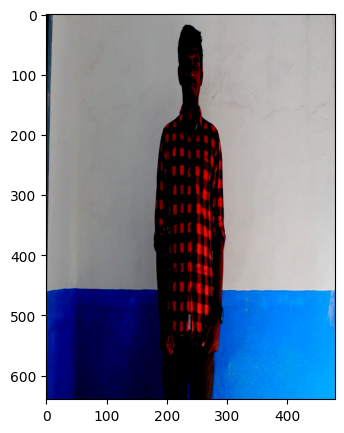

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
#sample_input = model_inputs_demo.pixel_values[0]
#
## Define original dimensions
#height =  sample_input.shape[2]
#width = sample_input.shape[3]
#
## Define the crop factor
#target_height = height - (height // 10) # Crop 10% of the height
#target_width =  width - (width // 2) # Crop 50% of width
#
## Define (Offset) the amount of crop required at each side of the image
#offset_height = (height - target_height) // 2
#offset_width = (width - target_width) // 2

In [ ]:
#sample_out = transforms.v2.functional.crop(sample_input, offset_height, offset_width, target_height, target_width)

In [ ]:
#print(sample_input.shape)
#print(sample_out.shape)

torch.Size([6, 3, 640, 480])
torch.Size([6, 3, 576, 240])


In [ ]:
#reshaped_video = sample_out.permute(0, 2, 3, 1)

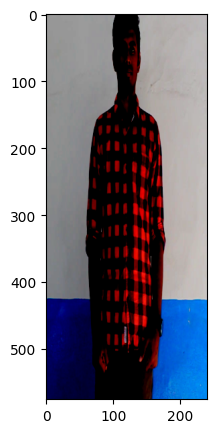

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
## Define a sample transformation pipeline
#transform_demo = transforms.Compose([
#    #transforms.RandomHorizontalFlip(),
#    #transforms.RandomVerticalFlip(),
#    #transforms.RandomResizedCrop(size=(640, 480), scale=(0.5, 1)),  # Zoom and crop # (1080, 1920)
#    transforms.v2.Resize((224, 224)),
#    transforms.v2.RandomPerspective(),
#    #transforms.v2.ColorJitter(brightness=(0.2, 0.8), contrast=(0.2, 0.8), saturation=(0.2, 0.8), hue=(-0.2, 0.2)),
#    transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
#    #transforms.v2.ColorJitter(),
#    #transforms.v2.RandomRotation(15),
#    #transforms.v2.ToImage(),
#    transforms.v2.ToDtype(torch.float32, scale=True)
#])

In [ ]:
#selected_video = sample_out
#print(len(selected_video))
#print(selected_video.shape)

6
torch.Size([6, 3, 576, 240])


In [ ]:
#augmented_video = transform_demo(selected_video)

In [ ]:
#print(augmented_video.shape)

torch.Size([6, 3, 224, 224])


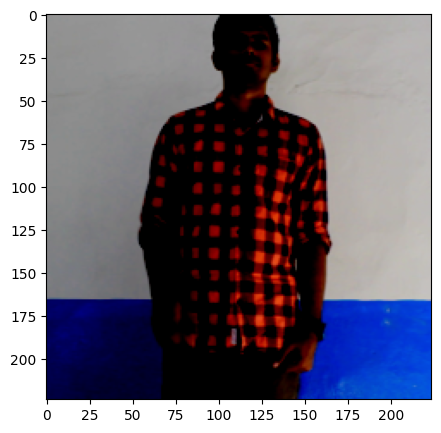

In [ ]:
#plt.imshow(augmented_video[4].permute(1, 2, 0))

In [ ]:
#print(augmented_video.max())
#print(augmented_video.min())

tensor(0.9091)
tensor(0.)


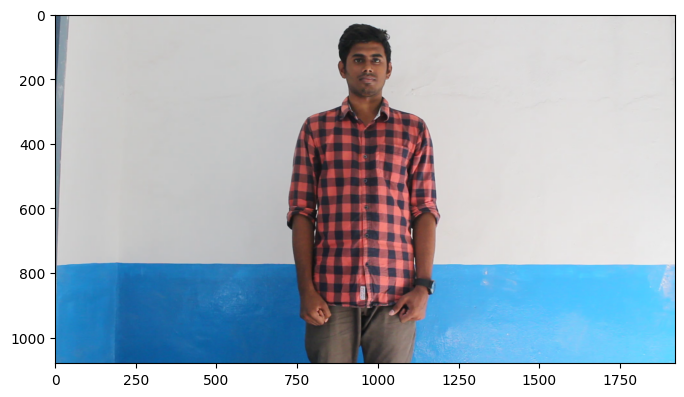

In [ ]:
#plt.imshow(key_frames[0])

# Create Dataset

In [59]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels):
        self.labels = labels.to('cpu')
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'labels': self.labels[idx],
            'pixel_values': self.pixel_values[idx],
        }
        return item

In [60]:
class CreateDataset():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a transformation pipeline
        self.transform_train = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.RandomPerspective(),
                                    transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

        # Define a sample transformation pipeline
        self.transform_val = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def crop_size(self, height, width):



        return offset_height, offset_width, target_height, target_width

    def create_dataset(self, video_paths, labels, training=True):
        pixel_values = []

        # Define Height and Width
        height = self.clip_size*4
        width = self.clip_size*8

        # Define the crop factor
        target_height = height - (height // 10) # Crop 10% of the height
        target_width =  width - (width // 2) # Crop 50% of width

        # Define (Offset) the amount of crop required at each side of the image
        offset_height = (height - target_height) // 2
        offset_width = (width - target_width) // 2


        for path in tqdm(video_paths):
            video = self.read_video(path)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*4, self.clip_size*8)) # Auto converts to (F, C, H, W) format

            if training:
                # Data Preperation for ML model with Augmentation
                video = transforms.v2.functional.crop(video, offset_height, offset_width, target_height, target_width)
                video = self.transform_train(video)
            else:
                # Data Preperation for ML Model without Augmentation
                video = self.transform_val(video)

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        labels = torch.tensor(labels, dtype=torch.int64).to(device)

        return CustomDataset(pixel_values=pixel_values,
                             labels=labels)

In [61]:
dataset_obj = CreateDataset(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS) #, CLIP_WIDTH, CLIP_HEIGHT)

In [62]:
1080/CLIP_SIZE

4.821428571428571

In [63]:
1920/CLIP_SIZE

8.571428571428571

# Testing the custome image processing class

## Stage 1 = read_video

In [44]:
sample_frames = dataset_obj.read_video(train_path[0])

In [45]:
print(sample_frames.shape)

torch.Size([32, 1080, 1920, 3])


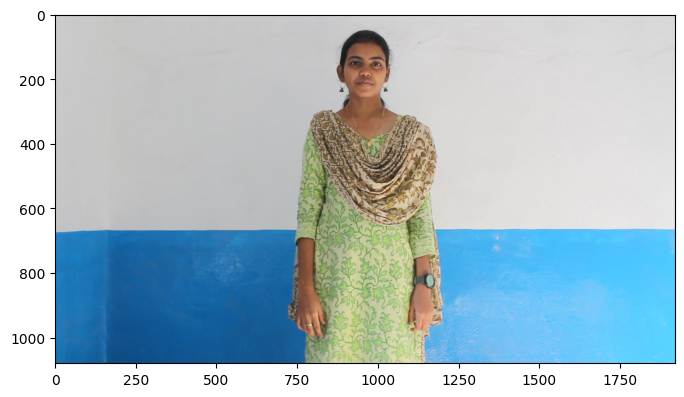

In [46]:
plt.imshow(sample_frames[0])

In [89]:
sample_torch_tensor = transforms.v2.functional.resize(sample_frames.permute(0, 3, 1, 2), size=[CLIP_SIZE*4, CLIP_SIZE*8])

In [90]:
sample_torch_tensor.shape

torch.Size([32, 3, 896, 1792])

In [99]:
# Define original dimensions
height = CLIP_SIZE*4 #sample_frames.shape[1]
width = CLIP_SIZE*8#sample_frames.shape[2]

# Define the crop factor
target_height = height - (height // 10) # Crop 10% of the height
target_width =  width - (width // 2) # Crop 50% of width

# Define (Offset) the amount of crop required at each side of the image
offset_height = (height - target_height) // 2
offset_width = (width - target_width) // 2

In [100]:
height

896

In [101]:
target_height

807

In [102]:
offset_height

44

In [103]:
sample_torch_tensor_crop = transforms.v2.functional.crop(sample_torch_tensor, offset_height, offset_width, target_height, target_width)#sample_frames.permute(0, 3, 1, 2)

In [104]:
print(sample_torch_tensor_crop.shape)

torch.Size([32, 3, 807, 896])


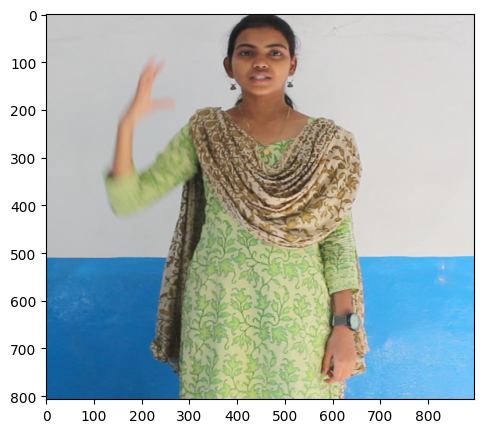

In [105]:
plt.imshow(sample_torch_tensor_crop[6].permute(1, 2, 0))

## Stage 2 = add_landmarks

In [ ]:
sample_landmarked_frames = dataset_obj.add_landmarks(sample_torch_tensor)

In [ ]:
print(sample_landmarked_frames.shape)

torch.Size([32, 448, 672, 3])


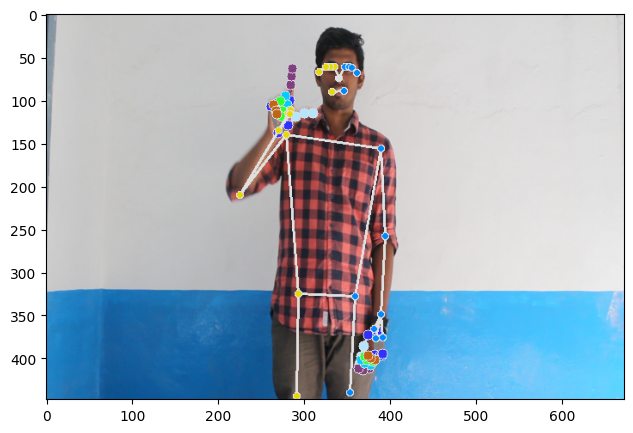

In [ ]:
sample_landmarked_frames_sc = (sample_landmarked_frames / 255)
plt.imshow(sample_landmarked_frames_sc[10])

## Stage 3 = Data Annotation - NOT USED

In [ ]:
#sample_annotated_frames = dataset_obj.data_augmentation(sample_landmarked_frames)

AttributeError: 'CreateDataset' object has no attribute 'data_augmentation'

In [ ]:
#print(sample_annotated_frames.shape)

torch.Size([32, 3, 224, 224])


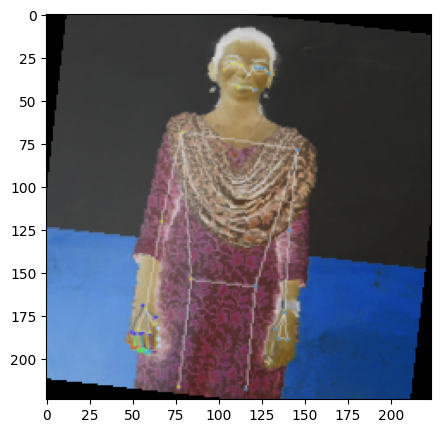

In [ ]:
#plt.imshow(sample_annotated_frames[0].permute(1, 2, 0))

## Stage 4 = Data Preprocessing - NOT USED

In [ ]:
#sample_annotated_frames = dataset_obj.data_prep_validation(sample_landmarked_frames)

In [ ]:
#print(sample_annotated_frames['pixel_values'].shape)

torch.Size([1, 32, 3, 224, 224])


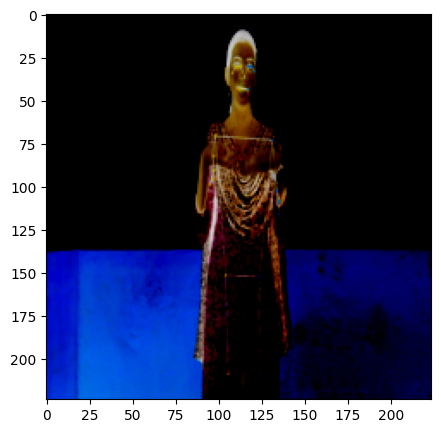

In [ ]:
#plt.imshow(sample_annotated_frames['pixel_values'].squeeze(0)[7].permute(1, 2, 0))

# Create DataLoader

In [64]:
train_ds = dataset_obj.create_dataset(train_path, train_label, training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/67 [00:00<?, ?it/s]

17

In [65]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([8, 32, 3, 224, 224]) torch.Size([8])


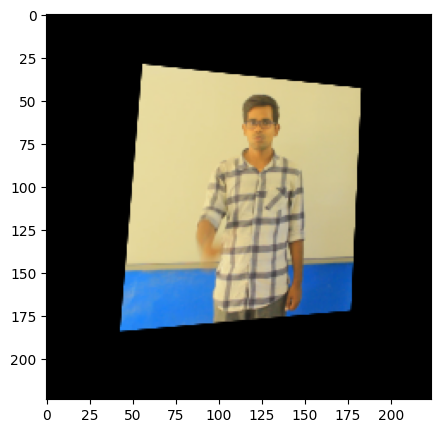

In [66]:
plt.imshow(inputs['pixel_values'][4,7].permute(1, 2, 0))

In [67]:
val_ds = dataset_obj.create_dataset(val_path, val_label, training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/17 [00:00<?, ?it/s]

17

In [68]:
# Example usage
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)

torch.Size([8, 32, 3, 224, 224]) torch.Size([8])


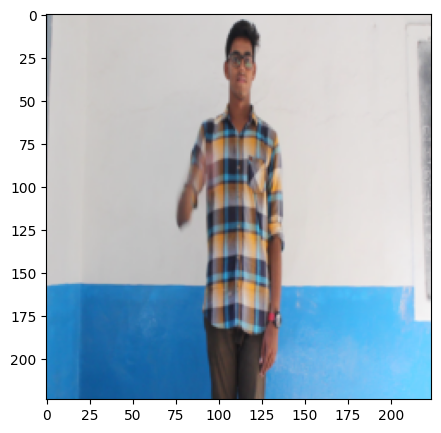

In [69]:
plt.imshow(inputs['pixel_values'][0,7].permute(1, 2, 0))

# Model Training

In [ ]:
#config_demo = VivitConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label)
#model_transformer = VivitForVideoClassification.from_pretrained(MODEL_TRANSFORMER, return_dict=True)

In [70]:
hyperparameters = {
    "learning_rate": 0.0002,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 5, # early stopping
    "output_dir_pt": f"{gdrive_path}/vivit_pytorch_GPU_3_withoutMediapipe",
    "output_dir_transformer": f"{gdrive_path}/vivit_pytorch_transformer_GPU_3_withoutMediapipe",
    "use_tpu": False,
    'dropout_rate': 0.2
}


In [71]:
# Now we train the model
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)
    accelerator.print

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate the model, chnage the final classification layer, let Accelerate handle the device placement.
    config = VivitConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,
                                         label2id=label_to_idx, num_labels=len(classes),
                                         return_dict=True, hidden_dropout_prob=hyperparameters['dropout_rate'],
                                         attention_probs_dropout_prob=hyperparameters['dropout_rate'],
                                         interpolate_pos_encoding=True,
                                         image_size=CLIP_SIZE,
                                         num_frames=CLIP_LENGTH,
                                         #num_attention_heads=2,
                                         #num_hidden_layers=2
                                         )
    model_transformer = VivitForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=config, ignore_mismatched_sizes=True) # MODEL_TRANSFORMER

    # Freeze the backbone
    #for param in model_transformer.vivit.parameters():
    #  param.requires_grad = False

    model_transformer.classifier = torch.nn.Linear(model_transformer.config.hidden_size, len(classes))

    torch.nn.init.xavier_uniform_(model_transformer.classifier.weight)
    torch.nn.init.zeros_(model_transformer.classifier.bias)

    model_transformer.gradient_checkpointing_enable()

    # Loss function
    #criterion = torch.nn.CrossEntropyLoss()

    # Instantiate optimizer
    optimizer = AdamW(model_transformer.parameters(), lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(model_transformer, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:

          # Forward pass
          outputs = accelerated_model(**batch)
          train_logits = outputs.logits
          #train_softmax = torch.nn.functional.softmax(train_logits, dim=-1)
          #train_preds = train_softmax.argmax(-1)

          # Labels
          train_labels = batch['labels']
          #train_loss = criterion(train_logits, train_labels)
          train_loss = torch.nn.functional.cross_entropy(input=train_logits, target=train_labels)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.step()
          acclerated_optimizer.zero_grad()

          # We gather the loss from the GPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          with torch.no_grad():
              outputs = accelerated_model(**batch)

          val_logits = outputs.logits
          #val_softmax = torch.nn.functional.softmax(val_logits, dim=-1)
          #val_preds = val_softmax.argmax(-1)
          val_labels = batch['labels']

          #val_loss = criterion(val_logits, val_labels)
          val_loss = torch.nn.functional.cross_entropy(input=val_logits, target=val_labels)

          # We gather the loss from the GPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model, hyperparameters['output_dir_pt'])
          accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

In [72]:
training_function()

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vivit-b-16x2/snapshots/fc341053d36b42d446b3ffccdbd52452712a23f3/config.json
Model config VivitConfig {
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "warm",
    "1": "wet",
    "2": "wide",
    "3": "young"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "warm": 0,
    "wet": 1,
    "wide": 2,
    "young": 3
  },
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 12,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.47.1",
  "tubelet_size": [
    2,
    16,
    16
  ]
}



pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vivit-b-16x2/snapshots/fc341053d36b42d446b3ffccdbd52452712a23f3/pytorch_model.bin
Attempting to create safetensors variant
Attempting to convert .bin model on the fly to safetensors.
All model checkpoint weights were used when initializing VivitForVideoClassification.

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 0: learning rate: [0.0002]
epoch 0: training loss: 2.5725089179144964
epoch 0: validation loss: 1.3483591079711914


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3_withoutMediapipe/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3_withoutMediapipe/model.safetensors


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0002]
epoch 1: training loss: 1.5795858171251085
epoch 1: validation loss: 1.48491636912028


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0002]
epoch 2: training loss: 1.6308677461412218
epoch 2: validation loss: 1.2744388580322266


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3_withoutMediapipe/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3_withoutMediapipe/model.safetensors


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0002]
epoch 3: training loss: 1.3978379567464192
epoch 3: validation loss: 2.029676914215088


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0002]
epoch 4: training loss: 1.4944036271837022
epoch 4: validation loss: 1.3996817270914714


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0002]
epoch 5: training loss: 1.4650569491916232
epoch 5: validation loss: 1.51939058303833


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 1.4680105845133464
epoch 6: validation loss: 1.3710153897603352


  0%|          | 0/9 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 1.3909356858995225
epoch 7: validation loss: 1.2785730361938477
Early stopping!


# Load model

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 5, # early stopping
    "output_dir_pt": f"{gdrive_path}/vivit_pytorch_GPU_3",
    "output_dir_transformer": f"{gdrive_path}/vivit_pytorch_transformer_GPU_3",
    "use_tpu": False,
    'dropout_rate': 0.2
}

In [ ]:
model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])
model_pretrained.eval()
print("Entire model loaded successfully!")

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_3/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.2,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 768,
  "id2label": {
    "0": "beautiful",
    "1": "happy",
    "2": "sad",
    "3": "tall",
    "4": "ugly",
    "5": "warm",
    "6": "wet",
    "7": "wide",
    "8": "young"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "beautiful": 0,
    "happy": 1,
    "sad": 2,
    "tall": 3,
    "ugly": 4,
    "warm": 5,
    "wet": 6,
    "wide": 7,
    "young": 8
  },
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 12,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version

Entire model loaded successfully!


In [ ]:
#model_pretrained = torch.load(hyperparameters['output_dir'], map_location=torch.device('cpu'))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

# Model testing

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [ ]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [ ]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProdData


In [ ]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

input path size: 7
['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prod_dl = DataLoader(prod_ds)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

torch.Size([1, 32, 3, 224, 224])


In [ ]:
predicted_label = []
for batch in tqdm(prod_dl):
  #print(batch['pixel_values'].shape)
  outputs = model_pretrained(**batch)
  logits = outputs.logits
  prod_softmax = torch.nn.functional.softmax(logits, dim=-1)
  predicted_label.append(prod_softmax.argmax(-1))
predicted_label = torch.cat(predicted_label)

In [ ]:
predicted_label

tensor([3, 5, 5, 7, 5, 5, 5])

In [ ]:
for val in predicted_label:
  print(idx_to_label[val.item()])

tall
warm
warm
wide
warm
warm
warm


In [ ]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

prod_2_tall.mov
prod_3_sad.mov
prod_1_ugly.mov
prod_4_short.mov
prod_5_tall.mov
prod_6_sad.mov
prod_7_quiet.mov


In [ ]:
idx_to_label

{0: 'beautiful',
 1: 'happy',
 2: 'sad',
 3: 'tall',
 4: 'ugly',
 5: 'warm',
 6: 'wet',
 7: 'wide',
 8: 'young'}

In [ ]:
#print(classification_report(test_label,predicted_label))

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)

In [ ]:
loss = torch.nn.functional.cross_entropy(input, target)
loss.backward()
print(input)
print(target)
print(loss)

tensor([[ 0.6744,  0.1843, -1.1494,  0.6776, -1.7125],
        [ 0.6602,  1.4167, -0.4237, -2.5425,  0.9023],
        [-1.5461, -0.3835, -0.3021, -0.3967, -0.4671]], requires_grad=True)
tensor([4, 3, 3])
tensor(3.2272, grad_fn=<NllLossBackward0>)


In [ ]:
input_softmax = torch.nn.functional.softmax(input, dim=-1)
loss = torch.nn.functional.cross_entropy(input_softmax, target)
loss.backward()
print(input)
print(input_softmax)
print(target)
print(loss)

tensor([[ 0.6744,  0.1843, -1.1494,  0.6776, -1.7125],
        [ 0.6602,  1.4167, -0.4237, -2.5425,  0.9023],
        [-1.5461, -0.3835, -0.3021, -0.3967, -0.4671]], requires_grad=True)
tensor([[0.3485, 0.2135, 0.0563, 0.3497, 0.0320],
        [0.2090, 0.4454, 0.0707, 0.0085, 0.2663],
        [0.0726, 0.2323, 0.2520, 0.2293, 0.2137]], grad_fn=<SoftmaxBackward0>)
tensor([4, 3, 3])
tensor(1.7273, grad_fn=<NllLossBackward0>)
